In [1]:
import pennylane as qml
from pennylane import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import collections
import tensorflow as tf

In [2]:
tf.config.set_visible_devices([], 'GPU')
tf.keras.backend.set_floatx('float64')

In [3]:
n_train = 2000
n_test  = 400
num_qubits = 4
n_weights = 3

batch_size = 5

In [4]:
dev = qml.device('lightning.qubit', wires=4)

#@partial(qml.batch_input, argnum = 1)
@qml.qnode(dev,interface="tf", diff_method="parameter-shift")
def circuit(inputs, weights):
    # Encoding of 4 classical input values
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)
        
    qml.RZ(weights[0], wires=[0])
    qml.RZ(weights[1], wires=[1])
    qml.CNOT(wires=[3, 2])
    qml.RZ(weights[2], wires=[3])

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

In [5]:
def QNN():
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4) 
    
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Counter({0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200})


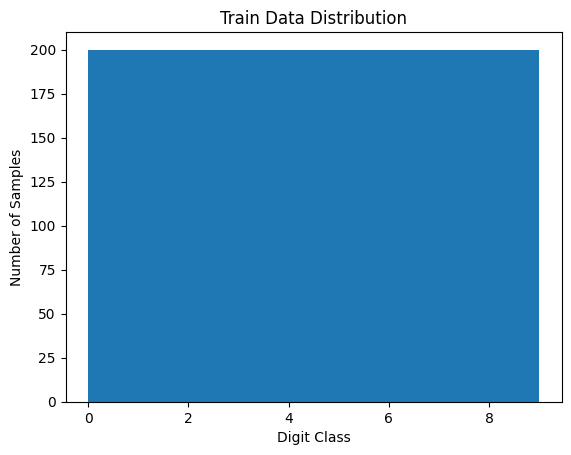

Counter({0: 40, 1: 40, 2: 40, 3: 40, 4: 40, 5: 40, 6: 40, 7: 40, 8: 40, 9: 40})


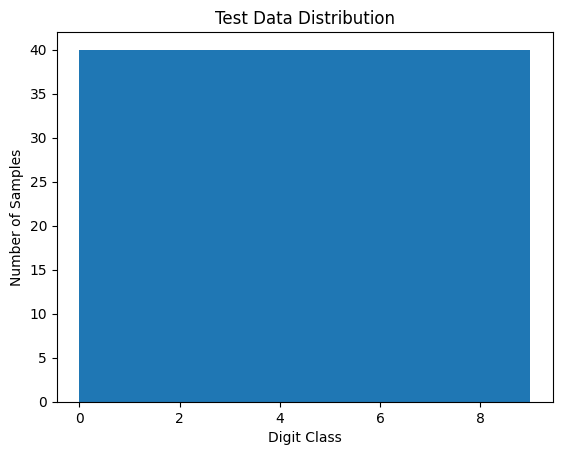

In [6]:
def load_dataset(train_size, test_size):
    mnist_dataset = keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

    # --- Train Set ---
    train_idx_by_class = [np.where(train_labels == i)[0] for i in range(10)]  
    train_idx_selected = [
        np.random.choice(idxs, min(len(idxs), train_size // 10), replace=False)  # Adjusted for train_size
        for idxs in train_idx_by_class
    ]
    train_idx_selected = np.concatenate(train_idx_selected) 

    train_images = train_images[train_idx_selected]
    train_labels = train_labels[train_idx_selected]

    # --- Test Set --- (Apply the same logic)
    test_idx_by_class = [np.where(test_labels == i)[0] for i in range(10)] 
    test_idx_selected = [
        np.random.choice(idxs, min(len(idxs), test_size // 10), replace=False)  # Adjusted for test_size
        for idxs in test_idx_by_class
    ]
    test_idx_selected = np.concatenate(test_idx_selected) 

    test_images = test_images[test_idx_selected]
    test_labels = test_labels[test_idx_selected]

    # Normalize pixel values within 0 and 1
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Add extra dimension for convolution channels
    train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
    test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
    
    #new_height = 14  # 28 / 2
    #new_width = 14  # 28 / 2 
    #train_images = tf.image.resize(train_images, (new_height, new_width))
    #test_images = tf.image.resize(test_images, (new_height, new_width))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_dataset(n_train, n_test)

label_counts = collections.Counter(train_labels)
print(label_counts)

plt.hist(train_labels)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Train Data Distribution')
plt.show()
label_counts = collections.Counter(test_labels)
print(label_counts)

plt.hist(test_labels)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Distribution')
plt.show()

/var/folders/vw/hv55q7kn1vl9cm96jf24vpkh0000gn/T/ipykernel_81328/2157209843.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


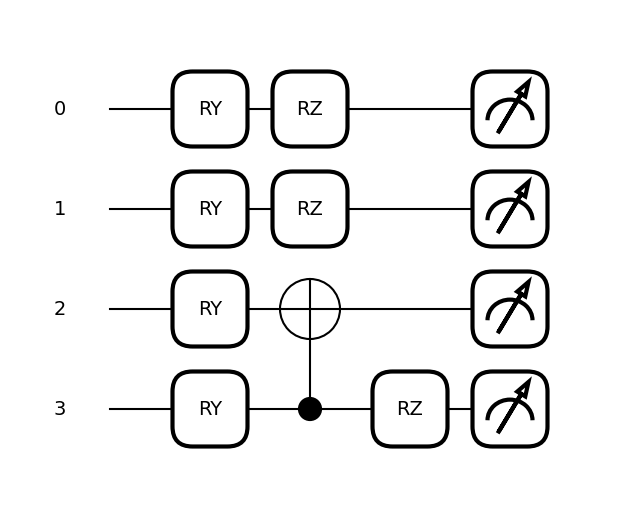

In [7]:
qlayer = qml.qnn.KerasLayer(circuit, {"weights": (n_weights,)}, output_dim=4)
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], [1,2,3,4,5])
fig.show()

In [8]:
def extract_all_patches(images):
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    
    return patches

In [9]:
class HQNNQuanv(tf.keras.Model):
    def __init__(self):
        super(HQNNQuanv, self).__init__()
        #self.batchnorm = tf.keras.layers.BatchNormalization(axis=1)
        self.quanv = qml.qnn.KerasLayer(circuit, {"weights": (n_weights,)}, output_dim=4)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(10, activation="softmax")
        
    def call(self, inputs):
        num_samples, height, width, num_channels = inputs.shape
        patches = extract_all_patches(inputs)
        
        batch_patches = patches
        batch_patches = tf.reshape(batch_patches, [-1,4])
        
        #start_time = time.process_time()
        quanvoluted_patches = tf.stack([self.quanv(patch) for patch in batch_patches])#circuit(batch_patches, self.quanv.get_weights()[0])
        #print(quanvoluted_patches)
        #print("Time to process patches: ", time.process_time() - start_time)
                    
        quanvoluted_patches = tf.reshape(quanvoluted_patches, [num_samples, 14, 14, 4])
        
        out = quanvoluted_patches
        #out = self.batchnorm(out)
        out = self.flatten(out)
        out = self.dense(out)
        return out

In [10]:
train_images_patches = extract_all_patches(train_images)

print(f"Train images shape is {train_images.shape}")
print(f"Train image patches shape is {train_images_patches.shape}")
print(f"Train label image shape is {train_labels.shape}")

test_images_patches = extract_all_patches(test_images)
print(f"Test images shape is {test_images.shape}")
print(f"Test image patches shape is {test_images_patches.shape}")
print(f"Test label image shape is {test_labels.shape}")

Train images shape is (2000, 28, 28, 1)
Train image patches shape is (2000, 14, 14, 4)
Train label image shape is (2000,)
Test images shape is (400, 28, 28, 1)
Test image patches shape is (400, 14, 14, 4)
Test label image shape is (400,)


In [ ]:
model = HQNNQuanv()
print(f"model_output_shape: {model(test_images).shape}")
model.summary()

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return 3e-4

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

r = model.fit(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels), batch_size = batch_size, callbacks=[lr_callback]) 

In [ ]:
def CNN():
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-3) 
    model = keras.models.Sequential([
        keras.layers.Conv2D(4, (2, 2), activation="relu", input_shape=(28, 28, 1)),
        #keras.layers.BatchNormalization(axis=1),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model2 = CNN()
hist2 = model2.fit(train_images, train_labels, validation_data = (test_images, test_labels), batch_size = 16, epochs=20, verbose=2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(r.history["val_accuracy"], "-ob", label="Quantum Convolutional Neural Network")
#ax1.plot(hist2.history["val_accuracy"], "-og", label="Classical Convolutional Neural Network")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(r.history["val_loss"], "-ob", label="Quantum Convolutional Neural Network")
#ax2.plot(hist2.history["val_loss"], "-og", label="Classical Convolutional Neural Network")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()